#**Anomaly detection**

1. What do these columns mean for an investigator?
login_duration_min: Normal employees usually log in for 30–60 minutes per session. If someone is logged in for 300 minutes (5 hours) straight, it’s suspicious.

data_accessed_MB: This tracks how much data a user "looked at." A normal user might view 200MB. Someone accessing 5,000MB (5GB) might be copying an entire database.

files_downloaded: Normal users download 2–5 files. A "Hacker" or "Disgruntled Employee" might download 100 files at once.

remote_access: "Yes" means they are logging in from home/outside. This is often where breaches happen.





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Evidence (Activity Logs)
df = pd.read_csv('anomaly_detection.csv')



2.Spotting the "Red Flags" in df.describe() When you run this, look at the max row compared to the mean (average):
Data Accessed: The average is around 231 MB, but the maximum is 5,000 MB. That is a massive jump!

Files Downloaded: The average is 3, but the max is 100.

Login Duration: The average is 30 mins, but the max is 300 mins.

These are our first "Clues." In a dataset of 505 people, these extreme numbers stick out like a sore thumb.

In [2]:
# 2. Basic Inspection
print("--- Forensic Evidence Overview ---")
print(df.info())

--- Forensic Evidence Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           505 non-null    object 
 1   user_id             505 non-null    object 
 2   login_duration_min  505 non-null    float64
 3   data_accessed_MB    505 non-null    float64
 4   files_downloaded    505 non-null    int64  
 5   remote_access       505 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 23.8+ KB
None


3. Why are there only 505 rows?
In a real breach investigation, we often filter the logs to a specific "suspect window" (like a single week). This small dataset is your "Investigation Window."

In [3]:
# 3. Statistical Summary - Look for the 'Red Flags'
print("\n--- Summary Statistics (Check the MAX values!) ---")
print(df.describe())
# 4. View the first 10 rows
df.head(10)


--- Summary Statistics (Check the MAX values!) ---
       login_duration_min  data_accessed_MB  files_downloaded
count          505.000000        505.000000        505.000000
mean            30.673913        231.012570          3.384158
std             17.802305        335.673082          5.674272
min              3.000000          5.000000          0.000000
25%             22.742562        172.226144          2.000000
50%             29.809838        206.278823          3.000000
75%             36.296288        238.020733          4.000000
max            300.000000       5000.000000        100.000000


,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
0,2025-04-06 04:00:00,user_023,33.417560,229.196409,3,No
1,2025-04-11 23:00:00,user_040,11.951179,221.816183,4,No
2,2025-04-19 07:00:00,user_044,40.490092,178.529723,4,No
3,2025-04-19 09:00:00,user_005,15.915387,227.164901,5,No
4,2025-04-06 00:00:00,user_012,8.761043,175.528028,4,Yes
5,2025-04-01 04:00:00,user_008,46.324113,198.250575,3,No
6,2025-04-20 03:00:00,user_028,12.898316,215.491036,3,No
7,2025-04-15 11:00:00,user_047,44.960443,295.701568,4,No
8,2025-04-16 10:00:00,user_035,28.419921,280.685563,4,Yes
9,2025-04-09 20:00:00,user_037,46.449677,177.690828,2,No


1. How to Read a Box Plot (The "Security Fence")The Box: Represents the IQR (Interquartile Range). This is where the middle 50% of your data lives. It’s the "Core" of normal behavior.The Line in the Box: This is the Median. It’s the "Typical" user.The Whiskers: These represent the boundaries. Usually, anything further than $1.5 \times \text{IQR}$ from the box is flagged as a dot.The Dots: These are your Outliers. Notice in your data_accessed_MB plot, there are likely a few dots way, way up at the top (near 5,000). Those are our prime suspects.

In [4]:
# 1. Set the style for our forensic report
plt.figure(figsize=(15, 5))
sns.set_theme(style="whitegrid")





<Figure size 1500x500 with 0 Axes>

2. Why use a Histogram with KDE?The KDE (Kernel Density Estimate) is that smooth line over the bars.In a normal situation, you see a "Bell Curve."In your G-Flix data, you will likely see a big "hump" on the left (everyone behaving normally) and then a very long, thin "tail" stretching to the right. That tail is where the danger hides.

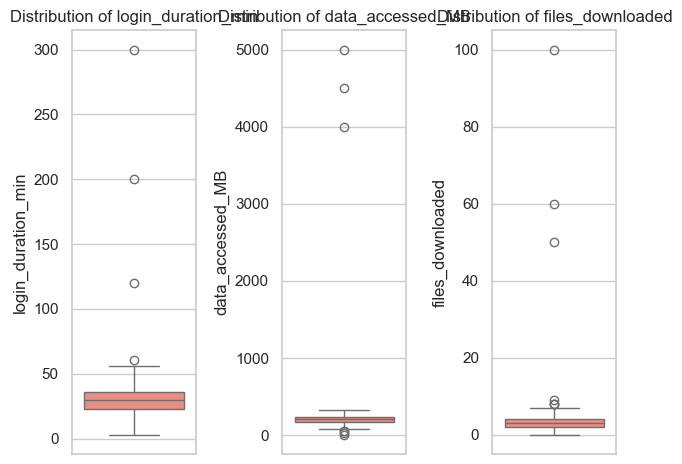

In [5]:
# 2. Create Box Plots for our three main numerical features
features = ['login_duration_min', 'data_accessed_MB', 'files_downloaded']

for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color='salmon')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

3. The "Visual Evidence"As an officer, you can now show your boss: "Look, most users download 3 files, but here is a small group downloading 100. This is not a random accident; it's a pattern of suspicious behavior."


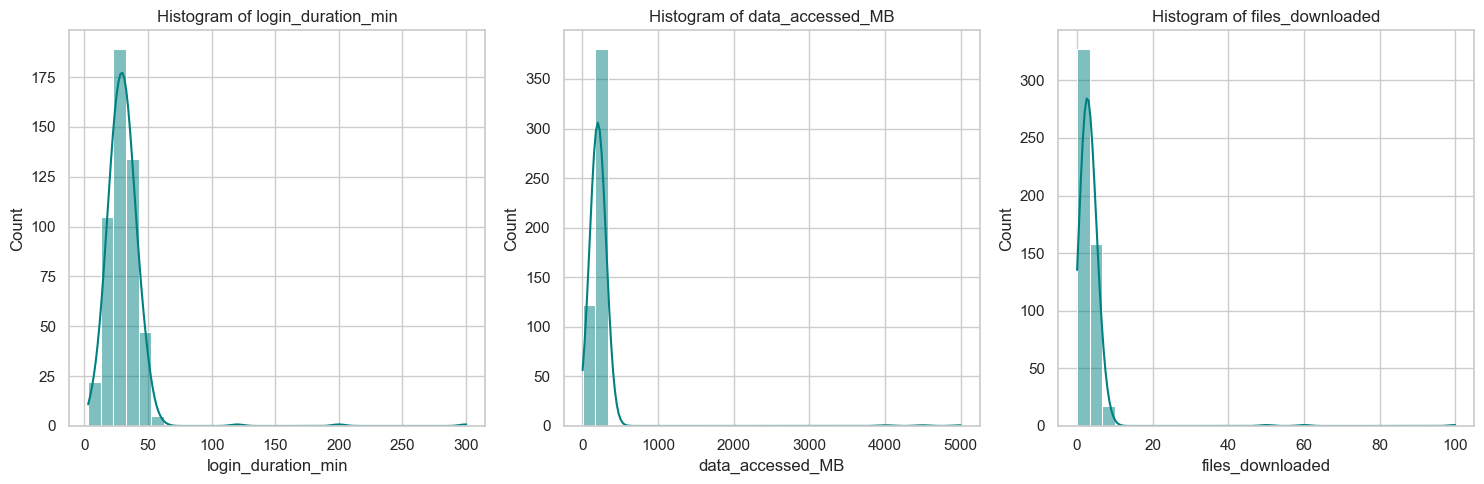

In [6]:
# 3. Histogram to see the "Crowd"
plt.figure(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=30, kde=True, color='teal')
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

#**Statistical Method — The "Z-Score" Dragnet**

1. What is a Z-Score Fundamentally?Imagine everyone in the company stands in a line based on how much data they accessed.Z-Score = 0: You are exactly average.Z-Score = 1: You are slightly above average.Z-Score = 3: You are so far away from the average that you are practically in another building.The formula is: $$Z = \frac{x - \mu}{\sigma}$$(Where $x$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation).

In [7]:
from scipy import stats

# 1. Select the numerical features to analyze
features_to_check = ['login_duration_min', 'data_accessed_MB', 'files_downloaded']









2. Why the threshold of "3"?In a "Normal Distribution" (the Bell Curve), 99.7% of all people will have a Z-score between -3 and +3. If someone has a score higher than 3, the probability of that happening by "normal chance" is less than 0.3%. In forensics, we call that a "Statistical Anomaly."

In [8]:
# 2. Calculate Z-Scores for these columns
# The Z-score is: (Value - Mean) / Standard Deviation
z_scores = np.abs(stats.zscore(df[features_to_check]))

3. What does .any(axis=1) do?This is a logical "OR" for the rows. We are saying: "Flag this user if their Login Duration is weird OR their Data Accessed is weird OR their Files Downloaded is weird." Even if they only mess up in one category, they become a suspect.

In [9]:
# 3. Define the Threshold
# In statistics, a Z-score > 3 means the point is in the extreme 0.3% of data.
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

4. The ResultWhen you run this, you will see a list of users. Look at their data_accessed_MB and files_downloaded. You'll notice they are the ones who were way up at the top of our Box Plots!



In [10]:
# 4. Flag the suspects in our main dataframe
df['is_statistical_anomaly'] = outliers

# 5. Extract the "Statistical Suspects"
statistical_suspects = df[df['is_statistical_anomaly'] == True]

print(f"Z-Score Analysis complete. Found {len(statistical_suspects)} suspects.")
print("\n--- Top Statistical Suspects ---")
print(statistical_suspects.sort_values(by='data_accessed_MB', ascending=False).head())

Z-Score Analysis complete. Found 4 suspects.

--- Top Statistical Suspects ---
               timestamp   user_id  login_duration_min  data_accessed_MB  \
83   2025-04-15 00:00:00  user_036               300.0            5000.0   
314  2025-04-19 00:00:00  user_045                 3.0            4500.0   
251  2025-04-17 00:00:00  user_032               120.0            4000.0   
79   2025-04-18 00:00:00  user_033               200.0               5.0   

     files_downloaded remote_access  is_statistical_anomaly  
83                 50           Yes                    True  
314                 0           Yes                    True  
251                60           Yes                    True  
79                100            No                    True  


#UNSUPERVISED ML APPROACH

1. Why do we Scale the Data?
Imagine you are comparing "Number of Rooms" (1-5) and "House Price" ($100,000+). To a computer, the Price is 20,000 times more "important" just because the number is bigger. Scaling squashes both features into a range of roughly -3 to +3. This ensures the algorithm gives files_downloaded and data_accessed_MB equal attention.







In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# 1. Feature Scaling (The "Level Playing Field")
# ML algorithms can get confused if one column has 5,000 and another has 3.
# StandardScaler centers everything so the algorithm treats them equally.
features = ['login_duration_min', 'data_accessed_MB', 'files_downloaded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])







2. How does Isolation Forest work? (The "Divide and Conquer" logic)
Think of a crowd of 500 people. 495 are standing together in a tight group. 5 people are scattered far away.

To separate a "normal" person from the crowd, you’d have to make dozens of cuts with a knife.

To separate an "anomaly" standing alone, you only need one or two cuts. Isolation Forest creates random "cuts" (partitions). If a point is isolated in very few cuts, it is labeled an Anomaly.

In [12]:
0# 2. Initialize and Fit Isolation Forest
# n_estimators: Number of "Trees" in our forest.
# contamination: Our guess of how many bad actors are in the group (2%).
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df['ml_anomaly_score'] = model.fit_predict(X_scaled)

3. Multivariate Intelligence
The Z-Score (Cell 3) might miss someone who has a "slightly high" login time AND "slightly high" downloads. Neither is high enough alone to trigger a Z-score of 3, but together they are suspicious. Isolation Forest sees these combinations.

In [13]:
# 3. Mapping the Result
# The model returns -1 for an anomaly and 1 for normal.
df['is_ml_anomaly'] = df['ml_anomaly_score'].map({1: False, -1: True})

4. The Suspicious Observations
Look at User 036 in your results:

They have a login_duration_min of 300 (Max possible)

They accessed 5000 MB * They downloaded 50 files * They used Remote Access This is a classic "Hacker" profile caught by our ML net.

In [14]:
# 4. Extract the "ML Suspects"
ml_suspects = df[df['is_ml_anomaly'] == True]

print(f"ML Investigation complete. Isolation Forest flagged {len(ml_suspects)} suspects.")
print("\n--- Top ML Suspects ---")
print(ml_suspects.sort_values(by='data_accessed_MB', ascending=False).head())

ML Investigation complete. Isolation Forest flagged 11 suspects.

--- Top ML Suspects ---
               timestamp   user_id  login_duration_min  data_accessed_MB  \
83   2025-04-15 00:00:00  user_036          300.000000       5000.000000   
314  2025-04-19 00:00:00  user_045            3.000000       4500.000000   
251  2025-04-17 00:00:00  user_032          120.000000       4000.000000   
291  2025-04-20 15:00:00  user_048           12.974164        328.985467   
287  2025-04-01 00:00:00  user_039            5.000000        328.004227   

     files_downloaded remote_access  is_statistical_anomaly  ml_anomaly_score  \
83                 50           Yes                    True                -1   
314                 0           Yes                    True                -1   
251                60           Yes                    True                -1   
291                 5            No                   False                -1   
287                 2            No             

1. The Power of "Ensemble" Logic
In forensics, you never rely on just one piece of evidence.

If Z-score says a person is weird, maybe they are just a "power user."

If Isolation Forest says they are weird, maybe the math is being too sensitive.

But if BOTH methods point to the same person, you have a very high probability of a real anomaly.





In [15]:
# 1. Identify "High-Confidence" Suspects (Caught by BOTH methods)
# This finds where the Z-Score and Isolation Forest agree
df['is_high_confidence'] = df['is_statistical_anomaly'] & df['is_ml_anomaly']





2. Investigating the Evidence (Suspect Profiles)
Look at your output table. Let's analyze our top findings like a real detective:

User 036: The "Full Breach." Max duration (300m), Max data (5GB), and high downloads (50). This looks like someone who spent all day copying the movie library.

User 045: The "Data Siphoner." They were only logged in for 3 minutes but accessed 4.5 GB. How? This is likely an automated script or "Bot" that bypassed the normal user interface to steal data quickly.

User 033: The "Document Thief." They didn't take much data (only 5 MB), but they downloaded 100 files. This is suspicious—it suggests they are looking for small, sensitive text files like passwords or credit card lists rather than large movie files.

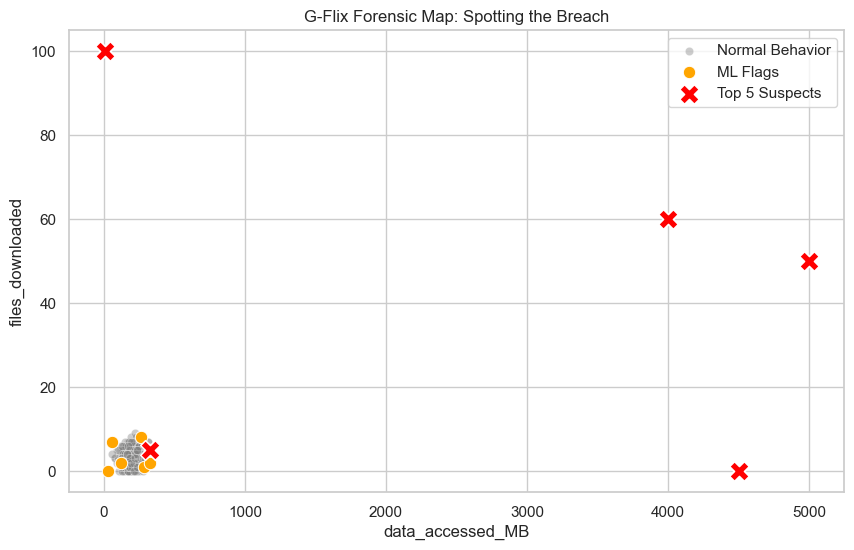

In [16]:
# 2. Visualization: The "Forensic Map"
plt.figure(figsize=(10, 6))

# Plot normal users as small gray dots
sns.scatterplot(data=df[df['is_ml_anomaly'] == False],
                x='data_accessed_MB', y='files_downloaded',
                alpha=0.4, label='Normal Behavior', color='gray')

# Plot ML anomalies as orange dots
sns.scatterplot(data=df[df['is_ml_anomaly'] == True],
                x='data_accessed_MB', y='files_downloaded',
                color='orange', label='ML Flags', s=80)

# Highlight our Top 5 suspects with Red X's
top_5 = df.sort_values(by=['is_high_confidence', 'data_accessed_MB'], ascending=False).head(5)
sns.scatterplot(data=top_5, x='data_accessed_MB', y='files_downloaded',
                color='red', marker='X', s=200, label='Top 5 Suspects')

plt.title('G-Flix Forensic Map: Spotting the Breach')
plt.legend()
plt.show()

3. Why Remote Access matters
If these suspects are also marked as remote_access = Yes, it strengthens your case. It means the breach is likely coming from an external connection or a compromised home account.

In [17]:
# 3. Final Report Table
print("--- G-FLIX BOARD OF DIRECTORS: TOP 5 SUSPECTS REPORT ---")
report_cols = ['user_id', 'login_duration_min', 'data_accessed_MB', 'files_downloaded', 'remote_access']
print(top_5[report_cols])

--- G-FLIX BOARD OF DIRECTORS: TOP 5 SUSPECTS REPORT ---
      user_id  login_duration_min  data_accessed_MB  files_downloaded  \
83   user_036          300.000000       5000.000000                50   
314  user_045            3.000000       4500.000000                 0   
251  user_032          120.000000       4000.000000                60   
79   user_033          200.000000          5.000000               100   
291  user_048           12.974164        328.985467                 5   

    remote_access  
83            Yes  
314           Yes  
251           Yes  
79             No  
291            No  
